<center><h1>Kalman Net for fisheye videos</h1></center>

This is the central file for the kalman net for fisheye videos project.
The objective of this file is to:
1) Extract annotations
2) Add noise to annotations
    - Add noise
    - Remove some
3) Train kalman net
4) Test kalman net

In [1]:
#Dependencies
import torch

#Initialisation
torch.set_default_tensor_type('torch.FloatTensor')
device = torch.device("cpu")

if (torch.cuda.is_available() and False):
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0")

Generate Data
----------------------

Data flow:<br>
<i>Generate</i> data_store [path numb [cx, cy, w, h]]<br>
-> <i>Add noise</i> -> base_data + noisy_data [path numb [cx, cy, w, h]]

In [2]:
import numpy as np
from scipy.interpolate import interp1d

num_points = 20
mx_v = 1
mn_v = 0

# Générer des coordonnées aléatoires pour les points
x = np.random.uniform(low=-mn_v, high=mx_v, size=num_points)
y = np.random.uniform(low=-mn_v, high=mx_v, size=num_points)

# Créer une fonction d'interpolation pour les coordonnées x et y
f_x = interp1d(np.arange(num_points), x, kind='cubic')
f_y = interp1d(np.arange(num_points), y, kind='cubic')

# Générer des points supplémentaires le long de la trajectoire
new_num_points = 100*num_points
new_x = f_x(np.linspace(0, num_points-1, new_num_points))
new_y = f_y(np.linspace(0, num_points-1, new_num_points))

data_store = [[[float(f_x(v)), float(f_y(v)), 1, 1] for v in np.linspace(0, num_points-1, new_num_points)]]

print("Number of paths: ", len(data_store))
for i in range(len(data_store[:5])):
    print("Path: ", i, " | Length:", len(data_store[i]))

Number of paths:  1
Path:  0  | Length: 2000


<h3>Add noise</h3>

In [3]:
#Dependencies
import numpy as np

In [4]:
#Variables
noise_mean = 0
noise_std = 0.005

In [5]:
#backup base data
import copy
base_data = copy.deepcopy(data_store)

In [6]:
#Loop over entire data and add noise
for t in range(len(data_store)):
    for f in range(len(data_store[t])):
        for i in range(len(data_store[t][f])):
            data_store[t][f][i] += np.random.normal(loc = noise_mean, scale = noise_std)
noisy_data = data_store #Rename variable

Visualisation
-------------

Visualise trajectories on a graph

In [7]:
#Dependencies
import matplotlib.pyplot as plt

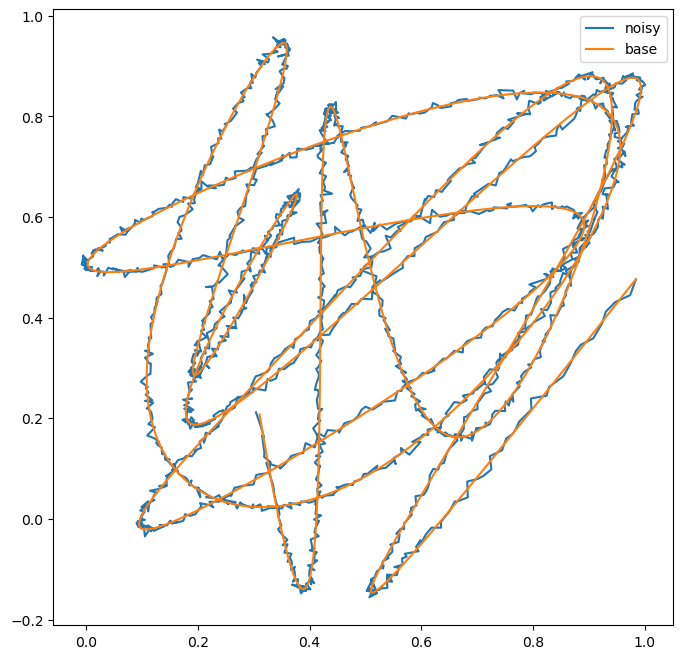

In [8]:
#Select section
id = 0

#Separating data
noise_values = [[], []]
base_values = [[], []]

for i in range(len(noisy_data[id])):
    f = base_data[id][i]
    f_noise = noisy_data[id][i]

    noise_values[0].append(sum([f_noise[0]]))
    noise_values[1].append(sum([f_noise[1]]))
    base_values[0].append(sum([f[0]]))
    base_values[1].append(sum([f[1]]))

#Plotting
fig, ax = plt.subplots(figsize=(8, 8))
#plt.xlim([0, 1])
#plt.ylim([0, 1])

plt.plot(noise_values[0], noise_values[1], label = "noisy")
plt.plot(base_values[0], base_values[1], label = "base")

plt.legend(loc="upper right")

Training Kalman model
---------------------

Source: https://github.com/KalmanNet/KalmanNet_TSP

Learn to use the KalmanNet_nn module

<h3>Create Model</h3>

-   Define dynamics
-   Create System model
-   Create Knet Model
-   Create KNet Pipeline (System model, Knet model)

<u>Model</u><br>
State vector : [posx, posy, velx, vely]<br>
F :<br>
[[1, 0, dt, 0],<br>
[0, 1, 0, dt],<br>
[0, 0, 1, 0],<br>
[0, 0, 0, 1]]<br>

In [9]:
from Linear_sysmdl import SystemModel
from KalmanNet_nn import KalmanNetNN
from Pipeline_KF import Pipeline_KF

In [10]:
#Define system properties
#   Dynamic variables
dt = 1/20 #Time between measurements
F = torch.tensor([ #Dynamic model for movement
    [1, 0, 0, 0, dt, 0, 0, 0],
    [0, 1, 0, 0, 0, dt, 0, 0],
    [0, 0, 1, 0, 0, 0, dt, 0],
    [0, 0, 0, 1, 0, 0, 0, dt],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1]
])
#   View variables
H = torch.eye(8)
#   Noise variables
_r = 0.1 #?
v = 10**(-20 / 10) #ratio v = _q/_r
_q = v * _r #?
r, q = torch.sqrt(torch.tensor(_r)), torch.sqrt(torch.tensor(_q))
#   Sequence lengths | for training and testing - defines the length of the paths - why the fuck is it defined here? I don't know... will prob change it dinamically and pray for the best...
T = 100
T_test = 100

In [11]:
#Create system model
sys_model = SystemModel(F, q, H, r, T, T_test)

In [12]:
#Initialization sequence - for automatic data generation (maybe?)
m1_0 = torch.tensor([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]])
m2_0 = 0 * 0 * torch.eye(8)

sys_model.InitSequence(m1_0, m2_0)

In [13]:
#Create NN model
KNet_model = KalmanNetNN()
KNet_model.Build(sys_model)

In [14]:
from datetime import datetime
today = datetime.today()
now = datetime.now()
strToday = today.strftime("%m.%d.%y")
strNow = now.strftime("%H:%M:%S")
strTime = strToday + "_" + strNow

#Create pipeline
KNet_Pipeline = Pipeline_KF(strTime, "KNet", "KNet_Network1.pt")
KNet_Pipeline.setssModel(sys_model)
KNet_Pipeline.setModel(KNet_model)

<h3>Preprocess data</h3>

- Format data
    - calculate velocity ([path [cx, cy, w, h]] -> [path [cx, cy, w, h, dcx, dcy, dw, dh]])
    - train, validate, test split
- Load data to torch

In [15]:
#Calculate velocity
#   Going to start with naive approach where velocity is determined exclusively from noisy for noisy and base for base

#Calculate velocity for base values
for i in range(len(base_data)):
    for r in range(len(base_data[i])):
        for j in range(len(base_data[i][r])):
            base_data[i][r].append( (base_data[i][r][j] - base_data[i][max(0, r - 1)][j]) / dt)

#Calculate velocity for noisy values
for i in range(len(noisy_data)):
    for r in range(len(noisy_data[i])):
        for j in range(len(noisy_data[i][r])):
            noisy_data[i][r].append( (noisy_data[i][r][j] - noisy_data[i][max(0, r - 1)][j]) / dt)

In [16]:
#Remove paths that are too short - assumption -> both arrays have already been sorted (big to small) and have the same length
cutoff = 10
cutoff_index = len(base_data) + 1

for i in range(len(base_data)):
    if len(base_data[i]) < cutoff:
        cutoff_index = i + 1
        break

base_data = base_data[:cutoff_index]
noisy_data = noisy_data[:cutoff_index]

In [17]:
#Load data into torch + add appropriate dimension (n, t, 8) -> (n, 8, t)
#   Convert each path to torch Tensor and load to gpu TODO: load to gpu

base_data_tensors = []
for n in base_data:
    base_data_tensors.append( torch.transpose( torch.Tensor(n) , 0, 1 ).to(device) )

noisy_data_tensors = []
for n in noisy_data:
    noisy_data_tensors.append( torch.transpose( torch.Tensor(n) , 0, 1 ).to(device) )

#Temporary
base_data_tensors = base_data_tensors[0]
noisy_data_tensors = noisy_data_tensors[0]

In [20]:
n_s = len(base_data_tensors[0])
n_tr = int(n_s * 0.70)
n_vl = int(n_s * 0.8)

X_train = noisy_data_tensors[None, :, :n_tr]
y_train = base_data_tensors[None, :, :n_tr]
X_val = noisy_data_tensors[None, :, n_tr:n_vl]
y_val = base_data_tensors[None, :, n_tr:n_vl]
X_test = noisy_data_tensors[None, :, n_vl:]
y_test = base_data_tensors[None, :, n_vl:]

print("\nTrain {} elements | Validate {} elements | Test {} elements".format(len(X_train[0][0]), len(X_val[0][0]), len(X_test[0][0])))


Train 1400 elements | Validate 200 elements | Test 400 elements


<h3>Train neural network</h3>

In [21]:
#Set training parameters
KNet_Pipeline.setTrainingParams(n_Epochs=20, n_Batch=30, learningRate=1E-3, weightDecay=1E-5)

In [22]:
new_T = min(len(X_train[0][0]), len(X_val[0][0]))
KNet_Pipeline.ssModel.T = new_T

KNet_Pipeline.NNTrain(1, X_train[:, :, :new_T], y_train[:, :, :new_T], 1, X_val[:, :, :new_T], y_val[:, :, :new_T])

0 MSE Training : tensor(228.1921) [dB] MSE Validation : tensor(226.3090) [dB]
Optimal idx: 0 Optimal : tensor(226.3090) [dB]
1 MSE Training : tensor(145.3442) [dB] MSE Validation : tensor(139.1008) [dB]
Optimal idx: 1 Optimal : tensor(139.1008) [dB]
2 MSE Training : tensor(217.1938) [dB] MSE Validation : tensor(211.3034) [dB]
diff MSE Training : tensor(71.8496) [dB] diff MSE Validation : tensor(72.2026) [dB]
Optimal idx: 1 Optimal : tensor(139.1008) [dB]
3 MSE Training : tensor(177.2793) [dB] MSE Validation : tensor(172.0840) [dB]
diff MSE Training : tensor(-39.9145) [dB] diff MSE Validation : tensor(-39.2194) [dB]
Optimal idx: 1 Optimal : tensor(139.1008) [dB]
4 MSE Training : tensor(141.3835) [dB] MSE Validation : tensor(139.0607) [dB]
diff MSE Training : tensor(-35.8958) [dB] diff MSE Validation : tensor(-33.0233) [dB]
Optimal idx: 4 Optimal : tensor(139.0607) [dB]
5 MSE Training : tensor(153.3708) [dB] MSE Validation : tensor(113.0343) [dB]
diff MSE Training : tensor(11.9874) [dB] 

In [23]:
KNet_Pipeline.save()

<h3>Testing and Visualizing</h3>

In [25]:
#Running network
x_test_in = X_train[0][None, :, :new_T].to(device)
y_test_in = y_train[0][None, :, :new_T].to(device)

N_T = x_test_in.shape[0]

#Change sequence lengths, temporary fix
KNet_Pipeline.ssModel.T = new_T

[KNet_MSE_test_linear_arr, KNet_MSE_test_linear_avg, KNet_MSE_test_dB_avg, KNet_test] = KNet_Pipeline.NNTest(N_T, x_test_in, y_test_in)

KNet_Network1.pt-MSE Test: tensor(61.9395) [dB]
KNet_Network1.pt-STD Test: tensor(nan) [dB]
Inference Time: 0.9746947288513184


C:\Users\benoi\AppData\Local\Temp\ipykernel_13232\1686571077.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


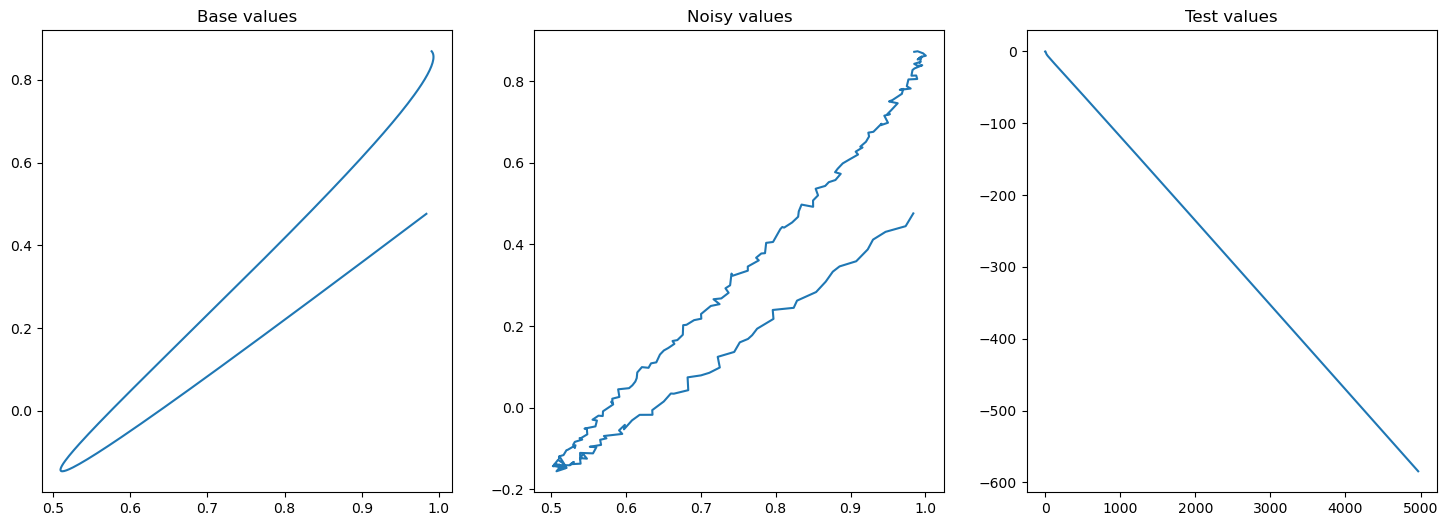

In [40]:
model_test_values = KNet_test.detach().numpy() #torch.transpose(KNet_test, 0, 1).detach().numpy()

#Plotting
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
# plt.xlim([0, 1])
# plt.ylim([0, 1])

axs[0].plot(base_values[0][:new_T], base_values[1][:new_T])
axs[0].set_title("Base values")

axs[1].plot(noise_values[0][:new_T], noise_values[1][:new_T])
axs[1].set_title("Noisy values")

axs[2].plot(model_test_values[0], model_test_values[1])
axs[2].set_title("Test values")

# plt.plot(noise_values[0], noise_values[1], label = "noisy")
# plt.plot(base_values[0], base_values[1], label = "base")

fig.show()